In [20]:
import numpy as np
from scipy.spatial import distance
import itertools

Multi-Instance Multi-Label Learning with Application to Scene Classification

In [211]:
def haussdorf_distance(A, B, metric='euclidean'):
    """Compute the Haussdorf distance between two bags-of-instances.
    
    Args:
        A (ndarray): A Na by m ndarray, where Na is the number of instances in the bag and m the number of features.
        B (nd.array): A Nb by m ndarray, where Nb is the number of instances in the bag and m the number of features.
        
    Return:
        The Haussdorf distance between the bags.
    """
    As, Bs = np.atleast_2d(A, B)    
    distances = distance.cdist(As, Bs)         
    max_a = np.max(np.min(distances, axis=1))
    max_b = np.max(np.min(distances, axis=0))
    return max(max_a, max_b)

In [212]:
rA = np.random.randn(100, 1024)
rB = np.random.randn(30, 1024)

In [213]:
%timeit haussdorf_distance(rA, rB)

100 loops, best of 3: 3.42 ms per loop


In [216]:
rA = np.random.randn(1024)
rB = np.random.randn(1024)
haussdorf_distance(rA, rB)

44.137868089203309

In [28]:
def gen_random_bags(n_bags=1000, n_instances_min=2, n_instances_max=200, n_features=1024, seed=42):
    np.random.seed(seed)
    ns_instance = np.random.randint(n_instances_min, n_instances_max, size=(n_bags, ))
    return [np.random.randn(ni, n_features) for ni in ns_instance]

In [300]:
class KMedoids(object):
    """K-medoids clustering of bags of instance.
        
    Args:
        n_clusters (int): The number of clusters to form as well as the number of medoids to generate.
        init (str): Method for initialization.
            ‘k-medoids++’ : selects initial cluster centers in a smart way to speed up convergence.
            ‘random’: choose k observations (rows) at random from data for the initial centroids.
        max_iter (int): Maximum number of iterations of the k-medoids algorithm.
        metric (str): Metric used to compute the Haussdorf distance between 2 bags.
        random_state (int): Seed for the numpy random number generator.
        
    Attributes:
        medoids (ndarray): k by m ndarray, where k is the number of clusters
            and m the dimension of the feature space.
    """
    
    def __init__(self, n_clusters, init='k-medoids++', max_iter=100, metric='euclidean', random_state=None):
        possible_init = {'k-medoids++', 'random'}
        if init not in possible_init:
            raise Exception("Init must be in {s}".format(s=possible_init))
            
        self.medoids = None
        self.__n_clusters = n_clusters
        self.__init_method = init
        self.__metric = metric
        self.__max_iter = max_iter
        self.__random_state = random_state
        self.__bags_hd_distances = None
        self.__medoids_ids = None
        self.__medoids_set = None
        self.__num_iter = 0
        self.__gamma_t = None
        self.__n_bags = 0
        self.__updated_medoids = None
        self.__converged = False
                
    def fit(self, X):
        """Compute k-Medoid clustering.
        
        Args:
            X (List[ndarray]): List of bags-of-instances. Each instance is a ni by m ndarray, 
                where ni is the number of instance in the bag i, and m is the number of features.
        """
        self._compute_bags_distances(X)
        self._init_medoids()

        while (self.__num_iter == 0 or not np.array_equal(self.__medoids_ids, self.__updated_medoids))\
               and self.__num_iter < self.__max_iter:
            self._update_medoids()
            self._associate_bags_to_medoids()
            self._find_medoids()
            self.__num_iter += 1
            
        self.medoids = [np.copy(bag) for i, bag in enumerate(X) if i in self.__medoids_set]
        self.__converged = (self.__num_iter < self.__max_iter)
    
    def transform(self, X):
        """Transform X to a cluster-distance space.
        
        Args:
            X (List[ndarray]): List of B bags-of-instances. Each instance is a ni by m ndarray, 
                where ni is the number of instance in the bag i, and m is the number of features.
                
        Returns:
            ndarray: A B by k ndarray, where B is the number of bags and k the number of medoids,
                containing the Haussdorf distance of every bag to every medoid. 
        """
        Z = np.zeros((len(X), self.__n_clusters))
        for i in xrange(len(X)):
            for k in xrange(self.__n_clusters):
                Z[i][k] = haussdorf_distance(self.medoids[k], X[i])
        return Z
    
    def fit_transform(self, X):
        """Compute k-Medoids clustering and transform X to a cluster-distance space.
        
        Args:
            X (List[ndarray]): List of B bags-of-instances. Each instance is a ni by m ndarray, 
                where ni is the number of instance in the bag i, and m is the number of features.
                
        Returns:
            ndarray: A B by k ndarray, where B is the number of bags and k the number of medoids,
                containing the Haussdorf distance of every bag to every medoid. 
        """
        self.fit(X)
        return self.transform(X)
    
    def predict(self, X):
        """Predict the closest cluster each bag-of-instances in X belongs to.
        
        Args:
            X (List[ndarray]): List of B bags-of-instances. Each instance is a ni by m ndarray, 
                where ni is the number of instance in the bag i, and m is the number of features.
                
        Returns:
            ndarray: A B by 1 ndarray, where B is the number of bags, containing the index
                of the closest medoid.
        """
        Z = self.transform(X)
        return np.argmin(Z, axis=1)
        
    
    def _compute_bags_distances(self, X):
        self.__n_bags = len(X)
        self.__bags_hd_distances = np.zeros((self.__n_bags, self.__n_bags))
        for i in xrange(len(X)):
            for j in xrange(i+1, self.__n_bags):
                self.__bags_hd_distances[i][j] = haussdorf_distance(X[i], X[j], metric=self.__metric)
                self.__bags_hd_distances[j][i] = self.__bags_hd_distances[i][j]

    def _init_medoids(self):
        if self.__random_state is not None:
            np.random.seed(self.__random_state)
            
        self.__num_iter = 0
        self.__converged = False
        
        if self.__init_method == 'k-medoids++':
            self._init_medoids_pp()
        else:
            # Select k random medoids
            self.__medoids_ids = np.random.choice(self.__n_bags, size=(self.__n_clusters, ), replace=False)
        self.__medoids_set = set(self.__medoids_ids)
        self.__updated_medoids = np.copy(self.__medoids_ids)
        
    def _init_medoids_pp(self):
        self.__medoids_ids = np.empty(shape=(self.__n_clusters, ), dtype=int)
        self.__medoids_ids[0] = np.random.randint(self.__n_bags)
        
        for k in xrange(1, self.__n_clusters):
            # Find the furthest from all medoids
            # N x k (k: number of medoids selected so far)
            hd_distances = self.__bags_hd_distances[:, self.__medoids_ids[:k]]
            # Maximize the minimum distance to a existing medoid.
            min_distance_to_medoid = np.min(hd_distances, axis=1)
            self.__medoids_ids[k] = np.argmax(min_distance_to_medoid)
        
    def _update_medoids(self):
        self.__medoids_ids = np.copy(self.__updated_medoids)
        self.__medoids_set = set(self.__medoids_ids)
            
    def _associate_bags_to_medoids(self):
        # Associate instances with their closest medoid.
        # N * k distances
        distances_to_medoids = self.__bags_hd_distances[:, self.__medoids_ids]
        closest_medoids = np.argmin(distances_to_medoids, axis=1) # (N, ) ndarray
        self.__gamma_t = [np.where(closest_medoids == i)[0] for i, t in enumerate(self.__medoids_ids)]
                  
    def _find_medoids(self):
        self.__updated_medoids = np.array([self._get_medoid(g) for g in self.__gamma_t])
        
    def _get_medoid(self, group):
        # G x G distances
        hd_distances = self.__bags_hd_distances[np.ix_(group, group)]
        sum_distances = np.sum(hd_distances, axis=1)
        return group[np.argmin(sum_distances)]
    

In [173]:
rbags = gen_random_bags(100, 2, 50, 256)

In [251]:
kmedoids = KMedoids(n_clusters=10, random_state=42)

In [252]:
kmedoids.fit(rbags)

In [253]:
rbags_test = gen_random_bags(70, 2, 50, 256)

In [254]:
kmedoids.predict(rbags_test)

array([2, 4, 6, 3, 6, 7, 4, 9, 4, 4, 7, 7, 3, 5, 3, 6, 7, 6, 4, 4, 5, 5, 6,
       4, 5, 6, 4, 5, 8, 5, 9, 2, 9, 4, 7, 2, 3, 2, 4, 7, 4, 9, 3, 4, 4, 2,
       6, 3, 6, 7, 4, 9, 6, 7, 4, 2, 9, 6, 4, 5, 5, 6, 6, 6, 7, 6, 5, 2, 3,
       7])

In [163]:
%time z = kmedoids.transform(rbags_test)

CPU times: user 1.78 s, sys: 9.28 ms, total: 1.79 s
Wall time: 1.8 s


In [164]:
z.shape

(200, 10)

In [168]:
import matplotlib.pyplot as plt
%matplotlib inline

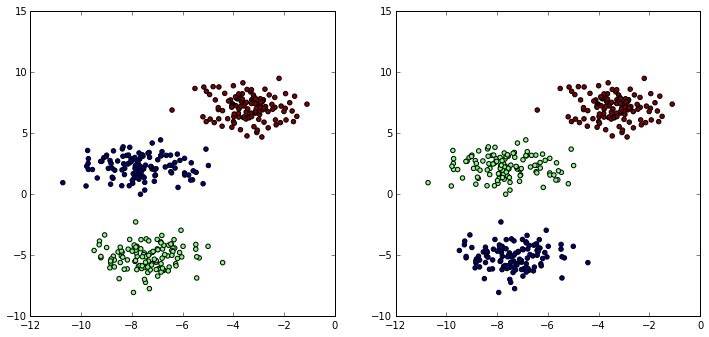

In [304]:
from sklearn.datasets import make_blobs
plt.figure(figsize=(12, 12))
n_samples = 350
random_state = 43
X, y = make_blobs(n_samples=n_samples, random_state=random_state)
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y)

#Transform X in a list of bag, each with one instance
Xbag = [x for x in X]
kmedoids = KMedoids(n_clusters=3, random_state=42)
kmedoids.fit(Xbag)
y_pred = kmedoids.predict(Xbag)
plt.subplot(222)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)